# [실무형 프로젝트] Predictive Maintenance – 이상 탐지 & 변수 예측

본 프로젝트에서는 공개 산업 데이터셋인 **AI4I 2020 Predictive Maintenance Dataset**을 활용하여,

- **이상 탐지(고장 여부 분류)**  
- **변수 예측(공구 마모 시간 Tool wear 회귀)**  

를 수행한다. 또한,

- 데이터 **불균형 처리**
- **모델 해석(Feature importance / SHAP 등)**
- **지표 최적화(Threshold, Cost 기반 Metric)**

를 통해 실무형 분석 역량을 검증하는 것을 목표로 한다.

---

## 데이터 설명

제공 파일: `ai4i2020.csv`

주요 컬럼 (예시):

- `UDI`: 고유 ID (정수)
- `Product ID`: 제품 ID (문자, 예: L47182, M14860, H45182)
- `Type`: 제품 타입 (카테고리: L, M, H 등)
- `Air temperature [K]`
- `Process temperature [K]`
- `Rotational speed [rpm]`
- `Torque [Nm]`
- `Tool wear [min]`
- `Target`: 기계 고장 여부 (0=정상, 1=고장)  ← **이상 탐지 타깃**
- `Failure type` 및 `TWF, HDF, PWF, OSF, RNF` 등 세부 고장 타입 (선택적으로 사용)

※ 실제 컬럼명은 제공된 csv를 기준으로 한다.


### Q1. 데이터 이해 및 이상/불균형 확인

1. `ai4i2020.csv` 파일을 불러와 DataFrame으로 저장하라.
2. 행/열 수, 자료형, 결측치 유무를 확인하라.
3. `Target`(또는 기계 고장 여부를 나타내는 이진 라벨)의
   - 각 클래스(0/1) 개수
   - 비율(%)을 계산하고, 단순 바 차트로 시각화하라.
4. 이 데이터에서 **이상(고장) 클래스가 불균형한지 여부를 설명하라.


=== Head ===
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0   

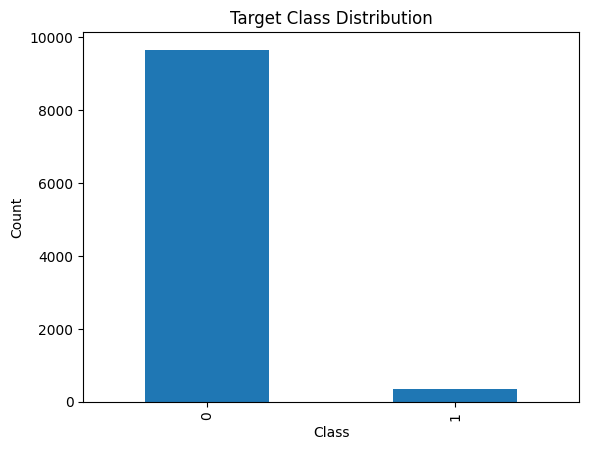

In [6]:
# Q1. 데이터 로드 및 EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 데이터 로드
# TODO: 파일 경로는 시험 환경에 맞게 수정
df = pd.read_csv("ai4i2020.csv")

# 2) 기본 정보 확인
print("=== Head ===")
print(df.head())

print("\n=== Info ===")
print(df.info())

print("\n=== Describe ===")
print(df.describe(include="all"))

print("\n=== Missing values ===")
print(df.isnull().sum())

# 3) 타깃 분포 확인
target_col = "Machine failure"  # 필요시 실제 타깃 컬럼명으로 수정
class_counts = df[target_col].value_counts()
class_ratio = df[target_col].value_counts(normalize=True) * 100

print("\n=== Target counts ===")
print(class_counts)
print("\n=== Target ratio (%) ===")
print(class_ratio)

# 4) 시각화
plt.figure()
class_counts.plot(kind="bar")
plt.title("Target Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 5) 불균형 여부에 대한 코멘트는 Markdown 셀에 작성


### Q2. 전처리 및 피처 엔지니어링

1. 모델 학습에 사용하지 않을 식별자 컬럼(예: `UDI`, `Product ID`)을 제거하라.
2. `Type`과 같이 범주형 컬럼은 One-Hot 인코딩을 수행하라.
3. 입력 피처 `X`와 타깃 `y`를 정의하라.
4. `train/valid/test` 세트를 **시간 정보가 없다면 단순 랜덤**으로,
   혹은 필요시 stratify 옵션을 사용하여
   - train 70%
   - valid 15%
   - test 15%
   로 분할하라.
5. 숫자 피처에 대해 `StandardScaler` 또는 `MinMaxScaler`를 적용하라.


In [8]:
# Q2. 전처리 및 피처 엔지니어링

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_proc = df.copy()

# 1) 식별자 제거 (필요에 따라 수정)
drop_cols = ["UDI", "Product ID"]  # 실제 컬럼명 기준
for c in drop_cols:
    if c in df_proc.columns:
        df_proc = df_proc.drop(columns=[c])

# 2) 범주형 One-Hot 인코딩
categorical_cols = []
if "Type" in df_proc.columns:
    categorical_cols.append("Type")

df_proc = pd.get_dummies(df_proc, columns=categorical_cols, drop_first=True)

# 3) X, y 분리
target_col = "Machine failure"  # 필요시 수정
X = df_proc.drop(columns=[target_col])
y = df_proc[target_col]

# 4) train / valid / test 분할 (불균형 → stratify 사용 권장)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1765,  # 0.15 / 0.85 ≈ 0.1765 → 최종 비율 70/15/15
    random_state=42,
    stratify=y_train_full
)

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape, "Test shape:", X_test.shape)

# 5) 스케일링 (숫자 피처 기준)
numeric_cols = X_train.columns  # 이미 One-Hot 후라 대부분 숫자
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)


Train shape: (6999, 12) Valid shape: (1501, 12) Test shape: (1500, 12)


### Q3. 베이스라인 이상 탐지 모델 (Logistic Regression)

1. 전처리된 데이터를 사용하여 **Logistic Regression** 모델을 학습하라.
2. 검증 세트(valid)에 대해
   - Accuracy
   - Precision, Recall, F1-score
   - ROC-AUC
   를 계산하라.
3. 혼동행렬(Confusion Matrix)을 출력하고,
   불균형 데이터에서 Accuracy만 보는 것의 한계를 설명하라.


In [9]:
# Q3. Logistic Regression 베이스라인

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# 1) 모델 학습
log_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)
log_clf.fit(X_train_scaled, y_train)

# 2) 예측 및 지표 계산
y_valid_pred = log_clf.predict(X_valid_scaled)
y_valid_proba = log_clf.predict_proba(X_valid_scaled)[:, 1]

acc  = accuracy_score(y_valid, y_valid_pred)
prec = precision_score(y_valid, y_valid_pred)
rec  = recall_score(y_valid, y_valid_pred)
f1   = f1_score(y_valid, y_valid_pred)
auc  = roc_auc_score(y_valid, y_valid_proba)

print("=== Logistic Regression (Valid) ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC-AUC  :", auc)

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_valid, y_valid_pred))

print("\n=== Classification Report ===")
print(classification_report(y_valid, y_valid_pred))


=== Logistic Regression (Valid) ===
Accuracy : 0.9986675549633578
Precision: 1.0
Recall   : 0.9607843137254902
F1       : 0.98
ROC-AUC  : 0.9724543610547668

=== Confusion Matrix ===
[[1450    0]
 [   2   49]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1450
           1       1.00      0.96      0.98        51

    accuracy                           1.00      1501
   macro avg       1.00      0.98      0.99      1501
weighted avg       1.00      1.00      1.00      1501



### Q4. 불균형 데이터 처리

1. `class_weight='balanced'` 옵션을 사용한 Logistic Regression 또는
   RandomForestClassifier를 학습하라.
2. (선택) `imblearn`의 SMOTE 또는 RandomUnderSampler 등을 사용하여
   train 데이터를 재샘플링한 모델도 추가로 학습하라.
3. Q3의 베이스라인과 비교하여
   - 특히 **소수 클래스(고장=1)**에 대한 Recall, F1, PR-AUC
   가 어떻게 변했는지 비교/설명하라.


In [10]:
# Q4. 불균형 처리 - class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score

# 1) class_weight를 사용한 모델 예시 (RandomForest)
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  # 불균형 처리
)
rf_clf.fit(X_train, y_train)  # 트리 기반은 스케일링 필요 X

y_valid_pred_rf  = rf_clf.predict(X_valid)
y_valid_proba_rf = rf_clf.predict_proba(X_valid)[:, 1]

acc_rf  = accuracy_score(y_valid, y_valid_pred_rf)
prec_rf = precision_score(y_valid, y_valid_pred_rf)
rec_rf  = recall_score(y_valid, y_valid_pred_rf)
f1_rf   = f1_score(y_valid, y_valid_pred_rf)
auc_rf  = roc_auc_score(y_valid, y_valid_proba_rf)
prauc_rf = average_precision_score(y_valid, y_valid_proba_rf)

print("=== RandomForest (class_weight=balanced, Valid) ===")
print("Accuracy :", acc_rf)
print("Precision:", prec_rf)
print("Recall   :", rec_rf)
print("F1       :", f1_rf)
print("ROC-AUC  :", auc_rf)
print("PR-AUC   :", prauc_rf)

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_valid, y_valid_pred_rf))

# (선택) SMOTE 등 재샘플링은 별도 코드 셀에 작성


=== RandomForest (class_weight=balanced, Valid) ===
Accuracy : 0.9986675549633578
Precision: 1.0
Recall   : 0.9607843137254902
F1       : 0.98
ROC-AUC  : 0.9770114942528737
PR-AUC   : 0.9621167587621325

=== Confusion Matrix ===
[[1450    0]
 [   2   49]]


### Q5. 지표 최적화 – Threshold & 비용 기반 Metric

다음과 같은 비용 구조를 가정한다.

- False Negative (FN: 실제 고장인데, 정상으로 예측): 비용 10
- False Positive (FP: 실제 정상인데, 고장으로 예측): 비용 1

1. Q4에서 성능이 더 좋았던 분류 모델 하나를 선택하라.
2. 검증 세트에 대해 예측 확률을 사용하여, 다양한 threshold (0.1 ~ 0.9)를 적용해
   - Precision, Recall, F1
   - FN, FP 개수 및 **비용 = 10×FN + 1×FP**
   를 계산하라.
3. 비용이 최소가 되는 threshold를 찾고, 그때의 Confusion Matrix와 지표를 제시하라.
4. 어떤 관점에서 이 threshold가 합리적인지 해석하라.


In [11]:
# Q5. Threshold & 비용 기반 Metric 최적화

import numpy as np

# 예시: RandomForest 확률 사용
valid_proba = y_valid_proba_rf  # 다른 모델을 쓸 경우 변경
y_true = y_valid.values

def evaluate_thresholds(y_true, y_proba, thresholds):
    results = []
    for th in thresholds:
        y_pred_th = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_th).ravel()

        prec = precision_score(y_true, y_pred_th, zero_division=0)
        rec  = recall_score(y_true, y_pred_th, zero_division=0)
        f1   = f1_score(y_true, y_pred_th, zero_division=0)

        cost = 10 * fn + 1 * fp  # 비용 정의

        results.append({
            "threshold": th,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "FP": fp,
            "FN": fn,
            "cost": cost
        })
    return pd.DataFrame(results)

thresholds = np.arange(0.1, 0.91, 0.05)
th_df = evaluate_thresholds(y_true, valid_proba, thresholds)
print(th_df)

best_row = th_df.loc[th_df["cost"].idxmin()]
best_th = best_row["threshold"]
print("\n=== Best threshold (min cost) ===")
print(best_row)

# 최적 threshold에서의 Confusion Matrix 출력
y_pred_best = (valid_proba >= best_th).astype(int)
print("\n=== Confusion Matrix @ best threshold ===")
print(confusion_matrix(y_true, y_pred_best))
print("\n=== Classification Report @ best threshold ===")
print(classification_report(y_true, y_pred_best))


    threshold  precision    recall        f1  FP  FN  cost
0        0.10   0.942308  0.960784  0.951456   3   2    23
1        0.15   1.000000  0.960784  0.980000   0   2    20
2        0.20   1.000000  0.960784  0.980000   0   2    20
3        0.25   1.000000  0.960784  0.980000   0   2    20
4        0.30   1.000000  0.960784  0.980000   0   2    20
5        0.35   1.000000  0.960784  0.980000   0   2    20
6        0.40   1.000000  0.960784  0.980000   0   2    20
7        0.45   1.000000  0.960784  0.980000   0   2    20
8        0.50   1.000000  0.960784  0.980000   0   2    20
9        0.55   1.000000  0.960784  0.980000   0   2    20
10       0.60   1.000000  0.941176  0.969697   0   3    30
11       0.65   1.000000  0.901961  0.948454   0   5    50
12       0.70   1.000000  0.882353  0.937500   0   6    60
13       0.75   1.000000  0.823529  0.903226   0   9    90
14       0.80   1.000000  0.764706  0.866667   0  12   120
15       0.85   1.000000  0.705882  0.827586   0  15   1

### Q6. 모델 해석 – Feature Importance / SHAP

1. Q4~Q5에서 최종 선택한 모델에 대해,
   - Feature importance (tree 기반 모델의 `feature_importances_`)를 계산하고,
     상위 10개 피처를 막대그래프로 시각화하라.
2. (선택) `shap` 라이브러리를 활용하여,  
   - 전체 데이터에 대한 `summary_plot`  
   - 개별 관측치(이상 사례)에 대한 `force_plot` 또는 `waterfall_plot`
   을 통해 모델이 어떤 피처에 의해 고장으로 판단했는지 해석하라.
3. 도메인 관점에서,  
   “어떤 센서/조건이 고장에 가장 큰 영향을 주는지”를 텍스트로 설명하라.


=== Top 10 feature importances ===
Torque [Nm]                0.183164
Rotational speed [rpm]     0.177962
PWF                        0.139737
HDF                        0.118612
Tool wear [min]            0.110681
TWF                        0.101229
OSF                        0.095122
Air temperature [K]        0.042491
Process temperature [K]    0.023273
Type_L                     0.003844
dtype: float64


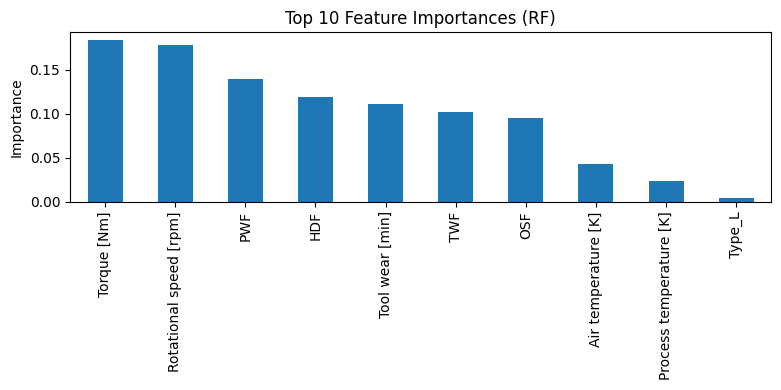

In [12]:
# Q6-1. Feature importance

importances = rf_clf.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

print("=== Top 10 feature importances ===")
print(feat_importance.head(10))

plt.figure(figsize=(8, 4))
feat_importance.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances (RF)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


### Q7. 변수 예측 태스크 – 공구 마모 시간 Tool wear 예측

이번에는 고장 여부가 아닌, **공구 마모 시간(`Tool wear [min]`)**을  
다른 피처들로부터 예측하는 회귀 모델을 구축한다.

1. `Tool wear [min]`을 타깃으로 하고, 나머지 피처들을 입력 변수로 사용하는
   회귀용 데이터셋을 구성하라.
   - 식별자(`UDI`, `Product ID`)는 제거
   - 범주형(`Type`)은 One-Hot 인코딩
2. train/valid/test로 다시 나누어(비율은 Q2와 동일하게 해도 무방),
   - Baseline 모델 (예: RandomForestRegressor, LightGBMRegressor 등)을 학습하라.
3. 검증 세트에서
   - MAE, RMSE, R²
   를 계산하라.
4. 피처 중요도를 분석하고,  
   “어떤 운전 조건에서 공구 마모가 커지는지”에 대해 해석하라.


=== RF Regression (Valid) ===
MAE : 49.95588637204827
RMSE: 60.44046977221721
R^2 : 0.09660003162944386

=== Top 10 feature importances (Regression) ===
Rotational speed [rpm]     0.261271
Torque [Nm]                0.252450
Air temperature [K]        0.206696
Process temperature [K]    0.188792
OSF                        0.026631
Type_L                     0.025590
Type_M                     0.022535
TWF                        0.012523
Machine failure            0.001257
RNF                        0.001048
dtype: float64


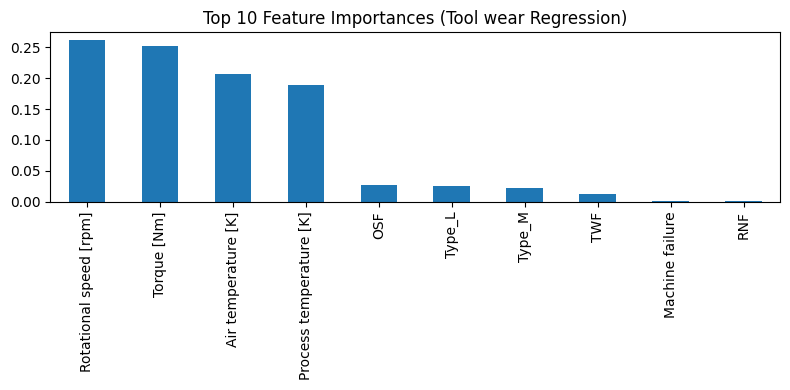

In [13]:
# Q7. Tool wear 회귀

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_reg = df.copy()

# 1) 식별자 제거
for c in ["UDI", "Product ID"]:
    if c in df_reg.columns:
        df_reg = df_reg.drop(columns=[c])

# 2) 범주형 인코딩
cat_cols_reg = []
if "Type" in df_reg.columns:
    cat_cols_reg.append("Type")

df_reg = pd.get_dummies(df_reg, columns=cat_cols_reg, drop_first=True)

# 3) X_reg, y_reg 정의
target_reg = "Tool wear [min]"  # 필요시 실제 컬럼명에 맞게 수정
X_reg = df_reg.drop(columns=[target_reg])
y_reg = df_reg[target_reg]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.15,
    random_state=42
)
X_train_reg2, X_valid_reg, y_train_reg2, y_valid_reg = train_test_split(
    X_train_reg, y_train_reg,
    test_size=0.1765,
    random_state=42
)

# 4) 회귀 모델 학습
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train_reg2, y_train_reg2)

y_valid_pred_reg = rf_reg.predict(X_valid_reg)

mae  = mean_absolute_error(y_valid_reg, y_valid_pred_reg)
rmse = np.sqrt(mean_squared_error(y_valid_reg, y_valid_pred_reg))
r2   = r2_score(y_valid_reg, y_valid_pred_reg)

print("=== RF Regression (Valid) ===")
print("MAE :", mae)
print("RMSE:", rmse)
print("R^2 :", r2)

# 5) 피처 중요도
reg_importance = pd.Series(rf_reg.feature_importances_, index=X_reg.columns).sort_values(ascending=False)
print("\n=== Top 10 feature importances (Regression) ===")
print(reg_importance.head(10))

plt.figure(figsize=(8, 4))
reg_importance.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances (Tool wear Regression)")
plt.tight_layout()
plt.show()


Full toolBox

In [ ]:
# ===== Dataset-specific config =====

CSV_PATH = "your_dataset.csv"  # 파일 경로

# (1) 분류 타깃 (이상 탐지용)
TARGET_COL = "Target"          # 예: "Target", "failure", "Class", "label" 등

# (2) 회귀 타깃 (변수 예측용) - 없으면 None
REG_TARGET_COL = "Tool wear [min]"  # 예: 없으면 None 으로 두고 회귀 파트 건너뛰기

# (3) ID/식별자 컬럼들 (모델에 쓰지 않을 것)
ID_COLS = ["UDI", "Product ID"]     # 없으면 빈 리스트 []

# (4) 범주형 컬럼들
CATEGORICAL_COLS = ["Type"]         # 없으면 빈 리스트 []

# ==============================


In [ ]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
# ID 제거
df_proc = df.drop(columns=[c for c in ID_COLS if c in df.columns])

# 범주형 인코딩
df_proc = pd.get_dummies(df_proc, columns=[c for c in CATEGORICAL_COLS if c in df_proc.columns],
                         drop_first=True)

# 분류용 X, y
X = df_proc.drop(columns=[TARGET_COL])
y = df_proc[TARGET_COL]
if REG_TARGET_COL is not None:
    df_reg = df.drop(columns=[c for c in ID_COLS if c in df.columns])
    df_reg = pd.get_dummies(df_reg,
                            columns=[c for c in CATEGORICAL_COLS if c in df_reg.columns],
                            drop_first=True)

    X_reg = df_reg.drop(columns=[REG_TARGET_COL])
    y_reg = df_reg[REG_TARGET_COL]
    # 이하 동일


만능툴박스

In [ ]:
# =========================
# 0. Dataset-specific config
# =========================

CSV_PATH = "your_dataset.csv"      # <-- 시험에서 주는 파일 이름으로 수정

# (1) 분류 타깃 (이상 탐지용)
TARGET_COL = "Target"              # 예: "Target", "Class", "failure", "label"

# (2) 회귀 타깃 (변수 예측용) – 없으면 None
REG_TARGET_COL = None              # 예: "Tool wear [min]" 또는 None

# (3) ID/식별자 컬럼들 (모델에 쓰지 않을 것)
ID_COLS = ["id", "UDI", "Product ID"]   # 없으면 [] 로 두거나, 없는 건 자동 무시됨

# (4) 범주형 컬럼들
CATEGORICAL_COLS = ["Type", "ProductType", "category"]  # 실제 있는 것만 사용됨

# (5) 랜덤 시드
RANDOM_STATE = 42


In [ ]:
# =========================
# 1. Load & basic EDA
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

df = pd.read_csv(CSV_PATH)

print("=== Head ===")
display(df.head())

print("\n=== Info ===")
print(df.info())

print("\n=== Missing values ===")
print(df.isnull().sum())

# 타깃 분포 (분류용 타깃이 실제 있을 때만)
if TARGET_COL in df.columns:
    print("\n=== Target value counts ===")
    print(df[TARGET_COL].value_counts())
    print("\n=== Target ratio (%) ===")
    print(df[TARGET_COL].value_counts(normalize=True) * 100)

    df[TARGET_COL].value_counts().plot(kind="bar")
    plt.title("Target Distribution")
    plt.show()


In [ ]:
# =========================
# 2. 공통 전처리 함수
# =========================

from sklearn.preprocessing import StandardScaler

def basic_preprocess_for_classification(
    df: pd.DataFrame,
    target_col: str,
    id_cols=None,
    cat_cols=None,
    random_state: int = 42,
    test_size: float = 0.15,
    val_size: float = 0.15,
):
    id_cols = id_cols or []
    cat_cols = cat_cols or []

    # 1) 타깃 제외한 데이터 복사
    df_proc = df.copy()

    # 2) 타깃/식별자 제거
    for c in id_cols:
        if c in df_proc.columns:
            df_proc = df_proc.drop(columns=[c])

    # 3) 범주형 인코딩 (있는 컬럼만)
    used_cat = [c for c in cat_cols if c in df_proc.columns]
    df_proc = pd.get_dummies(df_proc, columns=used_cat, drop_first=True)

    # 4) X, y 분리
    X = df_proc.drop(columns=[target_col])
    y = df_proc[target_col]

    # 5) train / test 분할
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y  # 분류 + 불균형 → stratify
    )

    # 6) train / valid 분할
    val_ratio_in_train = val_size / (1 - test_size)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_full, y_train_full,
        test_size=val_ratio_in_train,
        random_state=random_state,
        stratify=y_train_full
    )

    # 7) 스케일링 (선형모델/거리기반용)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled  = scaler.transform(X_test)

    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test":  X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test":  y_test,
        "X_train_scaled": X_train_scaled,
        "X_valid_scaled": X_valid_scaled,
        "X_test_scaled":  X_test_scaled,
        "scaler": scaler,
        "feature_names": X.columns
    }


In [ ]:
# 실제 호출 (분류용)
if TARGET_COL in df.columns:
    cls_data = basic_preprocess_for_classification(
        df,
        target_col=TARGET_COL,
        id_cols=ID_COLS,
        cat_cols=CATEGORICAL_COLS,
        random_state=RANDOM_STATE
    )


In [ ]:
# =========================
# 3. 평가 헬퍼 – 분류
# =========================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

def eval_classifier(y_true, y_pred, y_proba=None, print_report=True):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    if y_proba is not None:
        try:
            roc = roc_auc_score(y_true, y_proba)
        except ValueError:
            roc = np.nan
        prauc = average_precision_score(y_true, y_proba)
        metrics["roc_auc"] = roc
        metrics["pr_auc"] = prauc

    if print_report:
        print("Accuracy :", acc)
        print("Precision:", prec)
        print("Recall   :", rec)
        print("F1       :", f1)
        if y_proba is not None:
            print("ROC-AUC :", metrics["roc_auc"])
            print("PR-AUC  :", metrics["pr_auc"])
        print("\nConfusion Matrix")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification report")
        print(classification_report(y_true, y_pred, zero_division=0))

    return metrics


In [ ]:
# =========================
# 4. Threshold sweep + 비용 기반
# =========================

def sweep_thresholds(y_true, y_proba, fn_cost=10, fp_cost=1, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.1, 0.91, 0.05)

    rows = []
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        cost = fn_cost * fn + fp_cost * fp

        rows.append({
            "threshold": th,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "FP": fp,
            "FN": fn,
            "cost": cost
        })
    return pd.DataFrame(rows)


In [ ]:
# =========================
# 5. Baseline models
# =========================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_train_scaled = cls_data["X_train_scaled"]
X_valid_scaled = cls_data["X_valid_scaled"]
X_train        = cls_data["X_train"]
X_valid        = cls_data["X_valid"]
y_train        = cls_data["y_train"]
y_valid        = cls_data["y_valid"]

# 1) Logistic Regression (no class_weight)
log_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
log_clf.fit(X_train_scaled, y_train)

y_pred_log  = log_clf.predict(X_valid_scaled)
y_proba_log = log_clf.predict_proba(X_valid_scaled)[:, 1]

print("=== Logistic Regression (baseline) ===")
metrics_log = eval_classifier(y_valid, y_pred_log, y_proba_log)


# 2) RandomForest (no class_weight)
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

y_pred_rf  = rf_clf.predict(X_valid)
y_proba_rf = rf_clf.predict_proba(X_valid)[:, 1]

print("\n=== RandomForest (baseline) ===")
metrics_rf = eval_classifier(y_valid, y_pred_rf, y_proba_rf)


In [ ]:
# =========================
# 6. class_weight 로 불균형 처리
# =========================

# (1) LogisticRegression + class_weight
log_bal = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced"
)
log_bal.fit(X_train_scaled, y_train)

y_pred_logb  = log_bal.predict(X_valid_scaled)
y_proba_logb = log_bal.predict_proba(X_valid_scaled)[:, 1]

print("=== Logistic Regression (class_weight='balanced') ===")
metrics_logb = eval_classifier(y_valid, y_pred_logb, y_proba_logb)

# (2) RandomForest + class_weight
rf_bal = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"
)
rf_bal.fit(X_train, y_train)

y_pred_rfb  = rf_bal.predict(X_valid)
y_proba_rfb = rf_bal.predict_proba(X_valid)[:, 1]

print("\n=== RandomForest (class_weight='balanced') ===")
metrics_rfb = eval_classifier(y_valid, y_pred_rfb, y_proba_rfb)


In [ ]:
# =========================
# 7. 샘플링 – RandomOverSampler, RandomUnderSampler, SMOTE
# =========================

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# 예: SMOTE + RandomForest
smote = SMOTE(random_state=RANDOM_STATE)
rf_smote = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe_smote_rf = ImbPipeline(steps=[
    ("smote", smote),
    ("rf", rf_smote)
])

pipe_smote_rf.fit(X_train, y_train)

y_pred_smote  = pipe_smote_rf.predict(X_valid)
y_proba_smote = pipe_smote_rf.predict_proba(X_valid)[:, 1]

print("=== SMOTE + RandomForest ===")
metrics_smote = eval_classifier(y_valid, y_pred_smote, y_proba_smote)


In [ ]:
# RandomOverSampler + RF
ros = RandomOverSampler(random_state=RANDOM_STATE)
pipe_ros_rf = ImbPipeline([
    ("ros", ros),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])
pipe_ros_rf.fit(X_train, y_train)
y_pred_ros  = pipe_ros_rf.predict(X_valid)
y_proba_ros = pipe_ros_rf.predict_proba(X_valid)[:, 1]

print("=== RandomOverSampler + RF ===")
metrics_ros = eval_classifier(y_valid, y_pred_ros, y_proba_ros)


In [ ]:
# =========================
# 8. XGBoost & LightGBM
# =========================

from xgboost import XGBClassifier
import lightgbm as lgb

# (1) XGBoost – 불균형 처리: scale_pos_weight
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()  # 대략적인 비율

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_clf.fit(X_train, y_train)

y_pred_xgb  = xgb_clf.predict(X_valid)
y_proba_xgb = xgb_clf.predict_proba(X_valid)[:, 1]

print("=== XGBoost (scale_pos_weight) ===")
metrics_xgb = eval_classifier(y_valid, y_pred_xgb, y_proba_xgb)


In [ ]:
# =========================
# 9. Unsupervised anomaly detection
# =========================

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

X_all = cls_data["X_train"]  # 예시로 train 에서만
# 또는 df 전체에서 타깃 제거하고 넣어도 됨

# (1) Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # 예상 이상 비율(예: 5%)
    random_state=RANDOM_STATE
)
iso.fit(X_all)

# anomaly_score = -1 (이상), 1 (정상)
anomaly_pred_iso = iso.predict(X_all)    # -1, 1
anomaly_score_iso = iso.decision_function(X_all)  # 점수 (낮을수록 이상)

# (라벨이 있으면, TARGET_COL 이용해서 성능 비교도 가능)


In [ ]:
# =========================
# 10. Feature Importance – Tree-based
# =========================

feature_names = cls_data["feature_names"]

def plot_feature_importance(model, feature_names, top_n=15, title="Feature Importance"):
    importances = model.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    print(fi.head(top_n))

    plt.figure(figsize=(8, 4))
    fi.head(top_n).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_bal, feature_names, top_n=15,
                        title="RandomForest (class_weight) Feature Importance")


In [ ]:
from sklearn.inspection import permutation_importance
#permutation
result = permutation_importance(
    rf_bal,
    cls_data["X_valid"],
    cls_data["y_valid"],
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

perm_imp = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
print(perm_imp.head(15))

plt.figure(figsize=(8, 4))
perm_imp.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Permutation Importance (RF)")
plt.tight_layout()
plt.show()


In [ ]:
# =========================
# 11. SHAP – TreeExplainer
# =========================

import shap

# 트리 모델 기준 (RandomForest, XGBoost, LightGBM 모두 가능)
explainer = shap.TreeExplainer(rf_bal)

X_valid_sample = cls_data["X_valid"].sample(
    n=min(500, len(cls_data["X_valid"])),
    random_state=RANDOM_STATE
)
shap_values = explainer.shap_values(X_valid_sample)

# 이진분류에서 shap_values[1]이 클래스 1(이상)에 대한 값
shap.summary_plot(shap_values[1], X_valid_sample, show=False)
plt.title("SHAP Summary (class 1)")
plt.show()


In [ ]:
# =========================
# 12. 회귀용 전처리 + RF 모델
# =========================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def basic_preprocess_for_regression(
    df: pd.DataFrame,
    target_col: str,
    id_cols=None,
    cat_cols=None,
    random_state: int = 42,
    test_size: float = 0.15,
    val_size: float = 0.15,
):
    id_cols = id_cols or []
    cat_cols = cat_cols or []

    df_proc = df.copy()

    for c in id_cols:
        if c in df_proc.columns:
            df_proc = df_proc.drop(columns=[c])

    used_cat = [c for c in cat_cols if c in df_proc.columns]
    df_proc = pd.get_dummies(df_proc, columns=used_cat, drop_first=True)

    X = df_proc.drop(columns=[target_col])
    y = df_proc[target_col]

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )
    val_ratio_in_train = val_size / (1 - test_size)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_full, y_train_full,
        test_size=val_ratio_in_train,
        random_state=random_state
    )

    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test":  X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test":  y_test,
        "feature_names": X.columns
    }

def eval_regressor(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R^2 :", r2)
    return {"mae": mae, "rmse": rmse, "r2": r2}


In [ ]:
# 회귀 타깃이 있을 때만 실행
if REG_TARGET_COL is not None and REG_TARGET_COL in df.columns:
    reg_data = basic_preprocess_for_regression(
        df,
        target_col=REG_TARGET_COL,
        id_cols=ID_COLS,
        cat_cols=CATEGORICAL_COLS,
        random_state=RANDOM_STATE
    )

    X_train_reg = reg_data["X_train"]
    X_valid_reg = reg_data["X_valid"]
    y_train_reg = reg_data["y_train"]
    y_valid_reg = reg_data["y_valid"]

    rf_reg = RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf_reg.fit(X_train_reg, y_train_reg)

    y_pred_reg = rf_reg.predict(X_valid_reg)

    print("=== Regression (RandomForest) ===")
    metrics_reg = eval_regressor(y_valid_reg, y_pred_reg)

    # 중요도
    reg_importance = pd.Series(
        rf_reg.feature_importances_, index=reg_data["feature_names"]
    ).sort_values(ascending=False)
    print(reg_importance.head(15))


멀티

In [32]:
# 1. 설정 + 데이터 로드

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ===== 데이터셋 설정 =====
CSV_PATH = "ai4i2020.csv"   # 시험에서 주는 파일 이름에 맞게 수정

ID_COLS = ["UDI", "Product ID"]     # 모델에 쓰지 않을 식별자(있으면 제거)
CATEGORICAL_COLS = ["Type"]         # 범주형 컬럼 (One-Hot 대상)
RANDOM_STATE = 42

df = pd.read_csv(CSV_PATH)

print("=== Head ===")
display(df.head())
print("\n=== Info ===")
print(df.info())
print("\n=== Missing values ===")
print(df.isnull().sum())


=== Head ===


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0



=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float6

In [33]:
# 2. 멀티 클래스 라벨 생성

# 어떤 고장 타입 컬럼들이 있는지 확인
failure_flag_cols = [c for c in ["TWF", "HDF", "PWF", "OSF", "RNF"] if c in df.columns]
print("Failure flag columns:", failure_flag_cols)

def make_failure_type(row):
    # Target == 0 이면 무조건 "No Failure"
    if "Target" in row and row["Target"] == 0:
        return "No Failure"

    # Target == 1 이고, 각 failure 플래그 중 1인 것을 찾아서 이름으로 사용
    for col in failure_flag_cols:
        if col in row and row[col] == 1:
            return col

    # 혹시 어떤 이유로도 안 걸리면 Unknown
    return "Unknown"

df["FailureTypeMulti"] = df.apply(make_failure_type, axis=1)

print("=== FailureTypeMulti value counts ===")
print(df["FailureTypeMulti"].value_counts())
print("\n(비율)")
print(df["FailureTypeMulti"].value_counts(normalize=True) * 100)


Failure flag columns: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
=== FailureTypeMulti value counts ===
FailureTypeMulti
Unknown    9652
HDF         115
PWF          91
OSF          78
TWF          46
RNF          18
Name: count, dtype: int64

(비율)
FailureTypeMulti
Unknown    96.52
HDF         1.15
PWF         0.91
OSF         0.78
TWF         0.46
RNF         0.18
Name: proportion, dtype: float64


In [34]:
# 3. 라벨 인코딩 + 전처리

# 1) 라벨 인코딩 (문자 → 정수)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["FailureTypeLabel"] = le.fit_transform(df["FailureTypeMulti"])

print("라벨 인코딩 클래스들:", list(zip(le.classes_, range(len(le.classes_)))))

# 2) 전처리용 복사본 생성
df_proc = df.copy()

# 2-1) ID 컬럼 제거
for c in ID_COLS:
    if c in df_proc.columns:
        df_proc = df_proc.drop(columns=[c])

# 2-2) 문자열 라벨 컬럼(FailureTypeMulti) 제거
if "FailureTypeMulti" in df_proc.columns:
    df_proc = df_proc.drop(columns=["FailureTypeMulti"])

# 2-3) ❗타깃에 직결되는 고장 플래그/Target 제거 (데이터 누수 방지)
label_leak_cols = ["Target", "TWF", "HDF", "PWF", "OSF", "RNF"]
for c in label_leak_cols:
    if c in df_proc.columns:
        df_proc = df_proc.drop(columns=[c])

# 3) 범주형 One-Hot 인코딩
cat_cols = [c for c in CATEGORICAL_COLS if c in df_proc.columns]
df_proc = pd.get_dummies(df_proc, columns=cat_cols, drop_first=True)

# 4) X, y 분리
TARGET_COL_MULTI = "FailureTypeLabel"
X = df_proc.drop(columns=[TARGET_COL_MULTI])
y = df_proc[TARGET_COL_MULTI]

# (선택) 숫자형만 필터
X = X.select_dtypes(include=[np.number])

print("X dtypes:\n", X.dtypes.value_counts())
print("X shape:", X.shape, "y shape:", y.shape)


라벨 인코딩 클래스들: [('HDF', 0), ('OSF', 1), ('PWF', 2), ('RNF', 3), ('TWF', 4), ('Unknown', 5)]
X dtypes:
 float64    3
int64      3
Name: count, dtype: int64
X shape: (10000, 6) y shape: (10000,)


In [35]:
# 4. train / valid / test 분할 (멀티클래스 stratify)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y
)

val_ratio_in_train = 0.15 / 0.85  # 최종 70 / 15 / 15 비율 맞추기
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full,
    test_size=val_ratio_in_train,
    random_state=RANDOM_STATE,
    stratify=y_train_full
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)
print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True) * 100)


Train: (7000, 6) Valid: (1500, 6) Test: (1500, 6)

Train label distribution:
FailureTypeLabel
5    96.514286
0     1.157143
2     0.914286
1     0.771429
4     0.457143
3     0.185714
Name: proportion, dtype: float64


In [36]:
# 5. 평가 헬퍼 – 멀티클래스

from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix
)

def eval_multiclass(y_true, y_pred, label_encoder=None, title=""):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {title} ===")
    print("Accuracy   :", acc)
    print("Macro F1   :", macro_f1)
    print("Weighted F1:", weighted_f1)
    print("\nClassification Report:")

    if label_encoder is not None:
        target_names = label_encoder.classes_
        print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    else:
        print(classification_report(y_true, y_pred, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)

    # 간단한 heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_true)))
    plt.xticks(tick_marks, label_encoder.classes_ if label_encoder is not None else tick_marks, rotation=45)
    plt.yticks(tick_marks, label_encoder.classes_ if label_encoder is not None else tick_marks)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


=== RandomForest (baseline) ===
Accuracy   : 0.996
Macro F1   : 0.778689115185279
Weighted F1: 0.9953481523951089

Classification Report:
              precision    recall  f1-score   support

         HDF       0.94      0.94      0.94        17
         OSF       0.85      0.92      0.88        12
         PWF       0.93      0.93      0.93        14
         RNF       0.00      0.00      0.00         2
         TWF       1.00      0.86      0.92         7
     Unknown       1.00      1.00      1.00      1448

    accuracy                           1.00      1500
   macro avg       0.79      0.77      0.78      1500
weighted avg       0.99      1.00      1.00      1500


Confusion Matrix:
 [[  16    0    1    0    0    0]
 [   1   11    0    0    0    0]
 [   0    1   13    0    0    0]
 [   0    0    0    0    0    2]
 [   0    1    0    0    6    0]
 [   0    0    0    0    0 1448]]


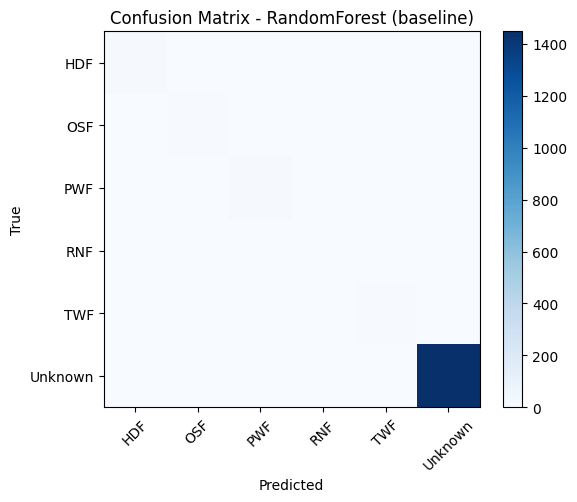

In [37]:
# 6. 멀티클래스 RandomForest (Baseline)

from sklearn.ensemble import RandomForestClassifier

rf_multi = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight=None   # 우선은 불균형 처리 없이
)

rf_multi.fit(X_train, y_train)

y_valid_pred_rf = rf_multi.predict(X_valid)

eval_multiclass(y_valid, y_valid_pred_rf, label_encoder=le, title="RandomForest (baseline)")


=== RandomForest (class_weight='balanced') ===
Accuracy   : 0.9953333333333333
Macro F1   : 0.7664343329304965
Weighted F1: 0.9947070127939693

Classification Report:
              precision    recall  f1-score   support

         HDF       0.94      0.94      0.94        17
         OSF       0.79      0.92      0.85        12
         PWF       0.92      0.86      0.89        14
         RNF       0.00      0.00      0.00         2
         TWF       1.00      0.86      0.92         7
     Unknown       1.00      1.00      1.00      1448

    accuracy                           1.00      1500
   macro avg       0.77      0.76      0.77      1500
weighted avg       0.99      1.00      0.99      1500


Confusion Matrix:
 [[  16    0    1    0    0    0]
 [   1   11    0    0    0    0]
 [   0    2   12    0    0    0]
 [   0    0    0    0    0    2]
 [   0    1    0    0    6    0]
 [   0    0    0    0    0 1448]]


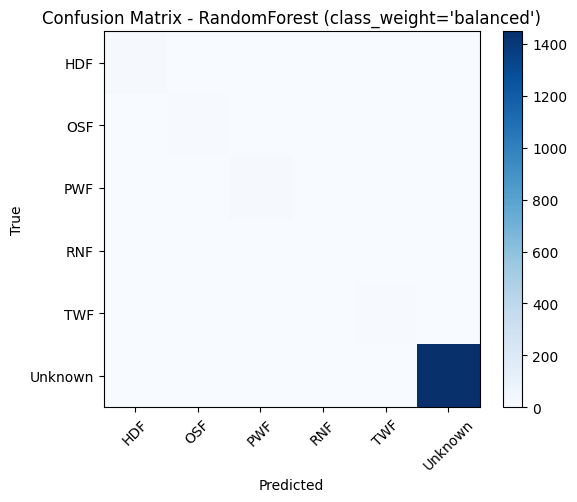

In [38]:
# 7. 멀티클래스 RandomForest + class_weight='balanced'

rf_multi_bal = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"   # 클래스 비율 역수로 가중치
)

rf_multi_bal.fit(X_train, y_train)

y_valid_pred_rfb = rf_multi_bal.predict(X_valid)

eval_multiclass(y_valid, y_valid_pred_rfb, label_encoder=le,
                title="RandomForest (class_weight='balanced')")


=== XGBoost (multiclass) ===
Accuracy   : 0.9953333333333333
Macro F1   : 0.7610863475825113
Weighted F1: 0.9946700897170463

Classification Report:
              precision    recall  f1-score   support

         HDF       0.94      0.94      0.94        17
         OSF       0.85      0.92      0.88        12
         PWF       0.92      0.86      0.89        14
         RNF       0.00      0.00      0.00         2
         TWF       0.86      0.86      0.86         7
     Unknown       1.00      1.00      1.00      1448

    accuracy                           1.00      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.99      1.00      0.99      1500


Confusion Matrix:
 [[  16    0    1    0    0    0]
 [   1   11    0    0    0    0]
 [   0    1   12    0    1    0]
 [   0    0    0    0    0    2]
 [   0    1    0    0    6    0]
 [   0    0    0    0    0 1448]]


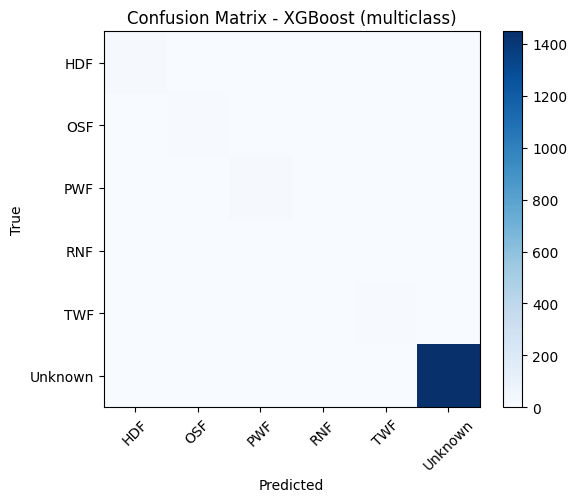

In [40]:
from xgboost import XGBClassifier

num_classes = y_train.nunique()

xgb_multi = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=num_classes,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="mlogloss"
)

# 🔥 여기서 DataFrame 대신 numpy로 넘기기
xgb_multi.fit(X_train.values, y_train.values)

y_valid_pred_xgb = xgb_multi.predict(X_valid.values)

eval_multiclass(
    y_valid,
    y_valid_pred_xgb,
    label_encoder=le,
    title="XGBoost (multiclass)"
)


In [ ]:
# 컬럼 이름에서 문제 되는 문자 제거/변환
def clean_col_name(c):
    c = str(c)
    c = c.replace("[", "(").replace("]", ")")
    c = c.replace("<", "lt_")
    return c

df_proc.columns = [clean_col_name(c) for c in df_proc.columns]


Top features:
Tool wear [min]            0.224565
Torque [Nm]                0.217534
Machine failure            0.176698
Rotational speed [rpm]     0.171644
Air temperature [K]        0.129151
Process temperature [K]    0.080408
dtype: float64


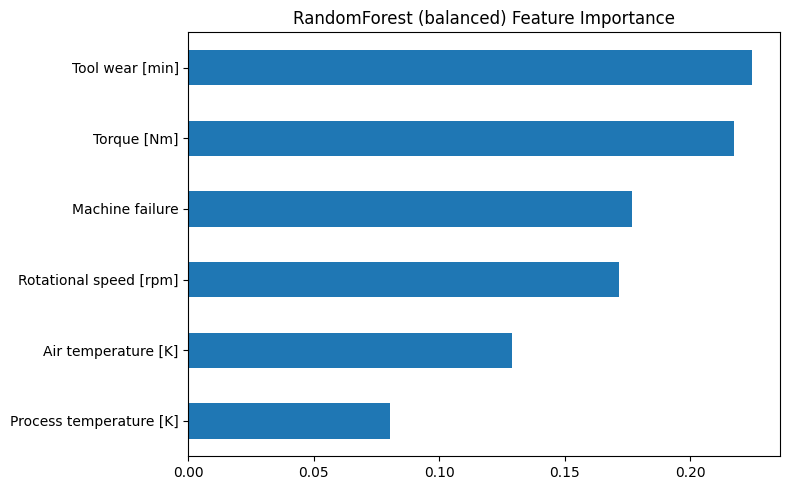

In [41]:
# 9. Feature Importance – 멀티클래스 모델 (트리 기반)

feature_names = X_train.columns

def plot_feature_importance(model, feature_names, top_n=15, title="Feature Importance"):
    importances = model.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    print("Top features:")
    print(fi.head(top_n))

    plt.figure(figsize=(8, 5))
    fi.head(top_n).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_multi_bal, feature_names,
                        top_n=15,
                        title="RandomForest (balanced) Feature Importance")


type(shap_values): <class 'numpy.ndarray'>
shap_values_arr.shape: (500, 6, 6)
=== SHAP summary for class: HDF (index 0) ===
  sv shape: (500, 6) / X_valid_sample shape: (500, 6)


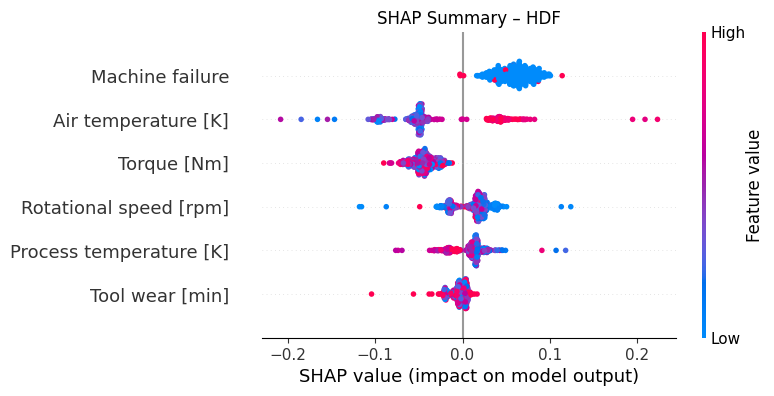

=== SHAP summary for class: OSF (index 1) ===
  sv shape: (500, 6) / X_valid_sample shape: (500, 6)


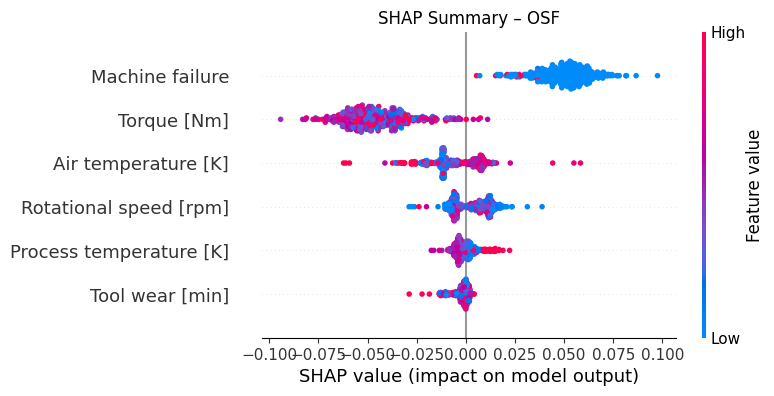

=== SHAP summary for class: PWF (index 2) ===
  sv shape: (500, 6) / X_valid_sample shape: (500, 6)


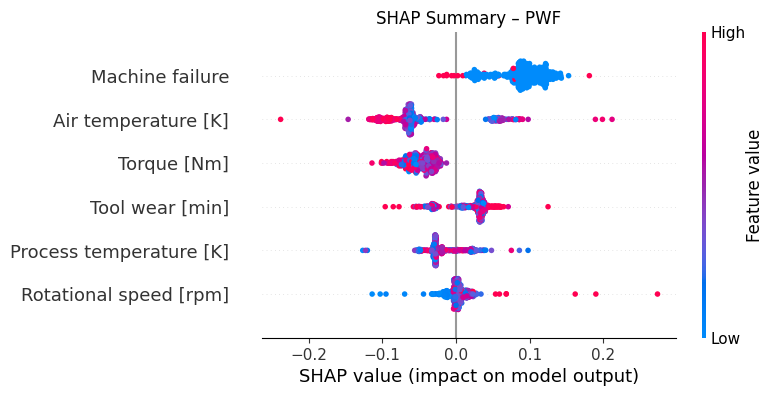

=== SHAP summary for class: RNF (index 3) ===
  sv shape: (500, 6) / X_valid_sample shape: (500, 6)


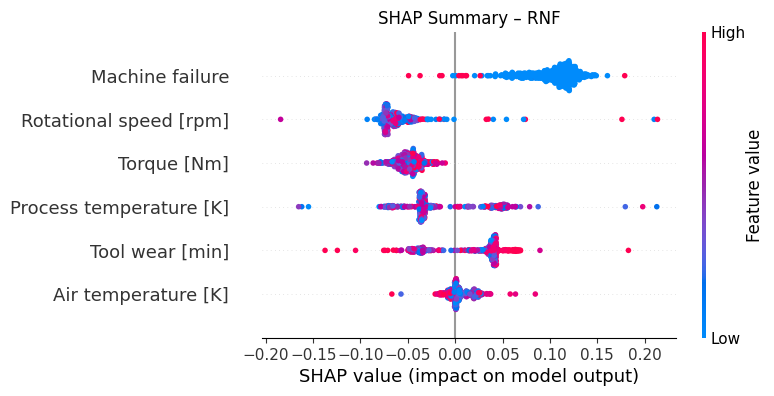

=== SHAP summary for class: TWF (index 4) ===
  sv shape: (500, 6) / X_valid_sample shape: (500, 6)


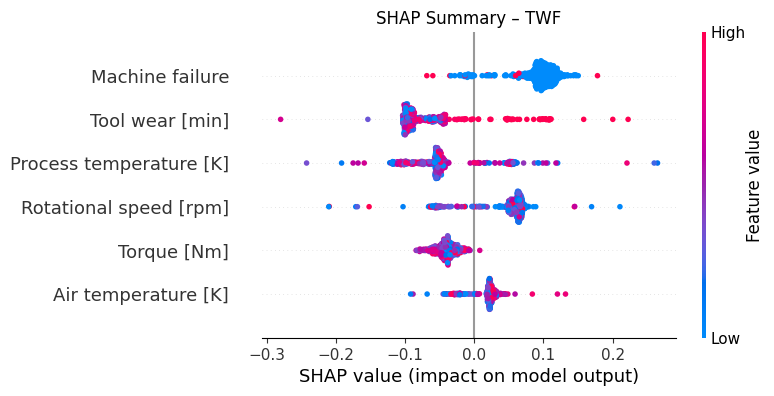

=== SHAP summary for class: Unknown (index 5) ===
  sv shape: (500, 6) / X_valid_sample shape: (500, 6)


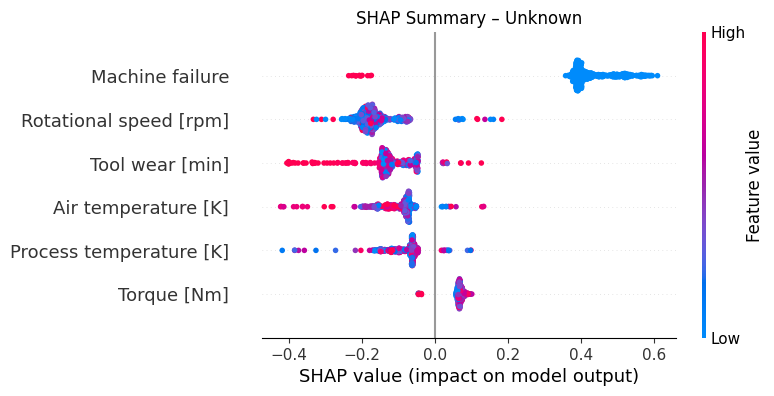

In [44]:
# 10. (선택) SHAP – 멀티클래스 (TreeExplainer)

import shap

# 1) 샘플 줄이기 (계산량 제한)
X_valid_sample = X_valid.sample(
    n=min(500, len(X_valid)),
    random_state=RANDOM_STATE
)

# 2) TreeExplainer 생성
explainer = shap.TreeExplainer(rf_multi_bal)

# 3) SHAP 값 계산 (반드시 X_valid_sample 기준으로 한 번만 계산)
shap_values = explainer.shap_values(X_valid_sample)

# 4) 리턴 타입에 따라 멀티클래스 처리 분기
#    - list: [ (n_samples, n_features), ... ]  (클래스별)
#    - ndarray: (n_samples, n_classes, n_features) 인 경우
import numpy as np

print("type(shap_values):", type(shap_values))

if isinstance(shap_values, list):
    # 고전적인 TreeExplainer 리턴 형태
    print("len(shap_values):", len(shap_values))
    for i, class_name in enumerate(le.classes_):
        if i >= len(shap_values):
            break  # 혹시 클래스 수가 안 맞으면 방어
        sv = shap_values[i]
        print(f"=== SHAP summary for class: {class_name} (index {i}) ===")
        print("  sv shape:", sv.shape, "/ X_valid_sample shape:", X_valid_sample.shape)
        shap.summary_plot(sv, X_valid_sample, show=False)
        plt.title(f"SHAP Summary – {class_name}")
        plt.show()

else:
    # shap_values가 numpy array인 경우 (예: (n_samples, n_classes, n_features))
    shap_values_arr = np.array(shap_values)
    print("shap_values_arr.shape:", shap_values_arr.shape)

    if shap_values_arr.ndim == 3:
        n_samples, n_classes, n_features = shap_values_arr.shape
        # 클래스별로 쪼개기: [ (n_samples, n_features), ... ]
        per_class_svs = [shap_values_arr[:, i, :] for i in range(n_classes)]

        for i, class_name in enumerate(le.classes_):
            if i >= len(per_class_svs):
                break
            sv = per_class_svs[i]
            print(f"=== SHAP summary for class: {class_name} (index {i}) ===")
            print("  sv shape:", sv.shape, "/ X_valid_sample shape:", X_valid_sample.shape)
            shap.summary_plot(sv, X_valid_sample, show=False)
            plt.title(f"SHAP Summary – {class_name}")
            plt.show()
    else:
        # 그 외 특이 케이스: 그냥 전체 평균 shap으로 한 번만 보기
        print("Unexpected shap_values shape, using single summary plot")
        shap.summary_plot(shap_values_arr, X_valid_sample, show=False)
        plt.title("SHAP Summary – all classes mixed")
        plt.show()


=== RandomForest (balanced) – TEST ===
Accuracy   : 0.9926666666666667
Macro F1   : 0.717425124330954
Weighted F1: 0.9916198936984586

Classification Report:
              precision    recall  f1-score   support

         HDF       0.85      1.00      0.92        17
         OSF       0.69      0.75      0.72        12
         PWF       0.91      0.77      0.83        13
         RNF       0.00      0.00      0.00         3
         TWF       1.00      0.71      0.83         7
     Unknown       1.00      1.00      1.00      1448

    accuracy                           0.99      1500
   macro avg       0.74      0.71      0.72      1500
weighted avg       0.99      0.99      0.99      1500


Confusion Matrix:
 [[  17    0    0    0    0    0]
 [   2    9    1    0    0    0]
 [   1    2   10    0    0    0]
 [   0    0    0    0    0    3]
 [   0    2    0    0    5    0]
 [   0    0    0    0    0 1448]]


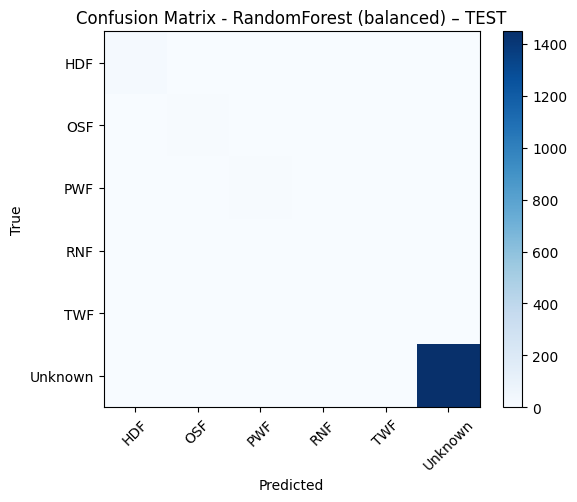

In [45]:
# 11. 최종 선택 모델로 Test 성능 평가 (예: rf_multi_bal 사용)

y_test_pred = rf_multi_bal.predict(X_test)
eval_multiclass(y_test, y_test_pred, label_encoder=le, title="RandomForest (balanced) – TEST")
